In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np

In [2]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 1e-4

ENCODER_1 = 256
ENCODER_2 = 128
ENCODER_3 = 64

LATENT_VECTOR = 32

DECODER_1 = 64
DECODER_2 = 128
DECODER_3 = 256

# 학습에 사용할 CPU나 GPU, MPS 장치를 얻습니다.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [3]:
# 공개 데이터셋에서 학습 데이터를 내려받습니다.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

view_data = training_data.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

# 학습 데이터를 학습/검증 데이터로 분리합니다.
training_data, validation_data = train_test_split(training_data, test_size=10000)

# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26421880/26421880 [00:01<00:00, 19732378.23it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 304363.25it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5501227.07it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13545970.51it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# 데이터로더를 생성합니다.
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

# 데이터의 형태를 확인합니다.
for X, y in test_dataloader:
    input_shape = X.shape[2] * X.shape[3]
    print(f"Shape of input: {input_shape}")
    num_class = len(y.unique())
    print(f"num of class: {num_class}")
    break

Shape of input: 784
num of class: 10


In [5]:
# AutoEncoder 모델을 정의합니다.
class Autoencoder(nn.Module):
    def __init__(self): #dropout_rate=0.3
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape,ENCODER_1),
            nn.ELU(),
            #nn.BatchNorm1d(ENCODER_1),
            #nn.Dropout(p=dropout_rate),
            nn.Linear(ENCODER_1, ENCODER_2),
            nn.ELU(),
            #nn.BatchNorm1d(ENCODER_2),
            #nn.Dropout(p=dropout_rate),
            nn.Linear(ENCODER_2, ENCODER_3),
            nn.ELU(),
            #nn.BatchNorm1d(ENCODER_3),
            #nn.Dropout(p=dropout_rate),
            nn.Linear(ENCODER_3, LATENT_VECTOR)
        )

        self.decoder = nn.Sequential(
            nn.Linear(LATENT_VECTOR, DECODER_1),
            nn.ELU(),
            #nn.BatchNorm1d(DECODER_1),
            nn.Linear(DECODER_1, DECODER_2),
            nn.ELU(),
            #nn.BatchNorm1d(DECODER_2),
            nn.Linear(DECODER_2, DECODER_3),
            nn.ELU(),
            #nn.BatchNorm1d(DECODER_3),
            nn.Linear(DECODER_3, input_shape),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = Autoencoder().to(device)
print(model)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)


In [6]:
# 손실함수와 optimizer를 설정합니다.
#loss_fn = nn.MSELoss()
loss_fn = nn.SmoothL1Loss()
#loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [7]:
# train 함수를 정의합니다.
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X = X.view(-1,28*28).to(device)

        # 복원 오차값(=손실값)을 계산합니다.
        recon = model(X)
        loss = loss_fn(recon, X)

        # 손실값을 역전파하여 모델을 갱신합니다.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [8]:
# test 함수를 정의합니다.
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, (X,y) in enumerate(dataloader):
            X = X.view(-1,28*28).to(device)

            recon = model(X)
            loss = loss_fn(recon, X)
            test_loss += loss
    test_loss /= num_batches
    return test_loss

Epoch 1
-------------------------------


782it [00:08, 92.56it/s]


[Epoch 0]


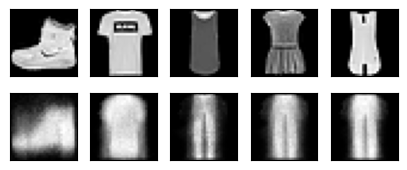

Train Error: 0.020388 

Validation Error: 0.020198 

Epoch 2
-------------------------------


782it [00:07, 108.01it/s]


[Epoch 1]


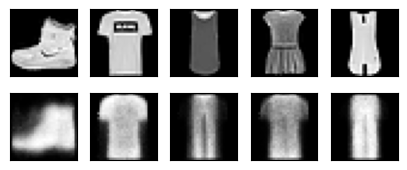

Train Error: 0.016515 

Validation Error: 0.016399 

Epoch 3
-------------------------------


782it [00:08, 95.61it/s] 


[Epoch 2]


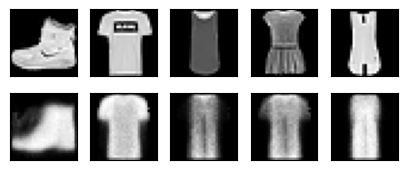

Train Error: 0.014962 

Validation Error: 0.014873 

Epoch 4
-------------------------------


782it [00:08, 88.31it/s] 


[Epoch 3]


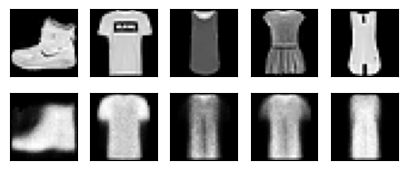

Train Error: 0.014070 

Validation Error: 0.014000 

Epoch 5
-------------------------------


782it [00:08, 95.91it/s]


[Epoch 4]


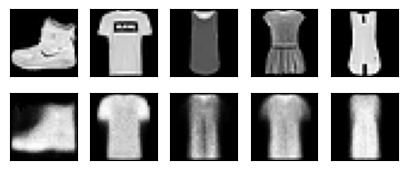

Train Error: 0.013573 

Validation Error: 0.013529 

Epoch 6
-------------------------------


782it [00:07, 105.36it/s]


[Epoch 5]


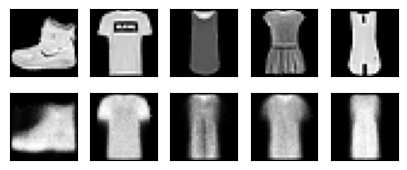

Train Error: 0.013111 

Validation Error: 0.013085 

Epoch 7
-------------------------------


782it [00:08, 90.70it/s] 


[Epoch 6]


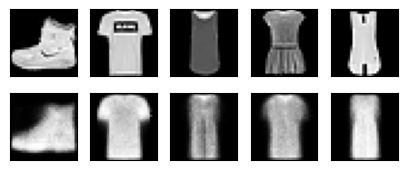

Train Error: 0.012287 

Validation Error: 0.012237 

Epoch 8
-------------------------------


782it [00:09, 81.82it/s] 


[Epoch 7]


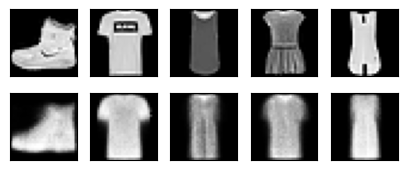

Train Error: 0.011835 

Validation Error: 0.011787 

Epoch 9
-------------------------------


782it [00:08, 89.17it/s]


[Epoch 8]


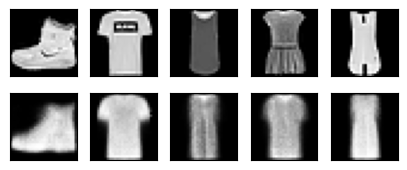

Train Error: 0.011528 

Validation Error: 0.011480 

Epoch 10
-------------------------------


782it [00:07, 101.83it/s]


[Epoch 9]


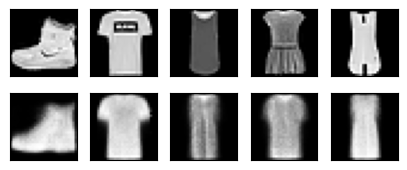

Train Error: 0.011163 

Validation Error: 0.011118 

Epoch 11
-------------------------------


782it [00:09, 83.66it/s] 


[Epoch 10]


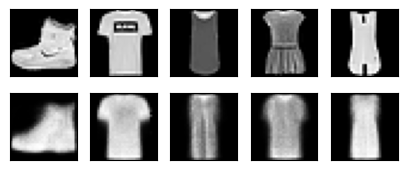

Train Error: 0.010823 

Validation Error: 0.010777 

Epoch 12
-------------------------------


782it [00:09, 84.21it/s] 


[Epoch 11]


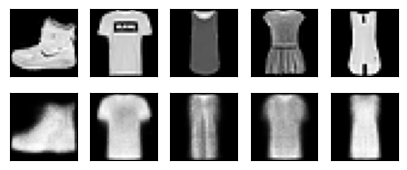

Train Error: 0.010557 

Validation Error: 0.010509 

Epoch 13
-------------------------------


782it [00:09, 83.98it/s]


[Epoch 12]


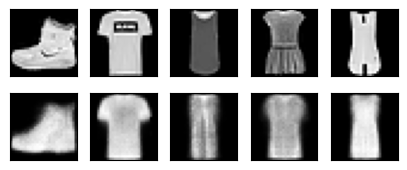

Train Error: 0.010337 

Validation Error: 0.010289 

Epoch 14
-------------------------------


782it [00:08, 89.55it/s]


[Epoch 13]


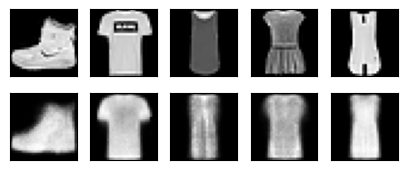

Train Error: 0.010111 

Validation Error: 0.010061 

Epoch 15
-------------------------------


782it [00:08, 96.62it/s]


[Epoch 14]


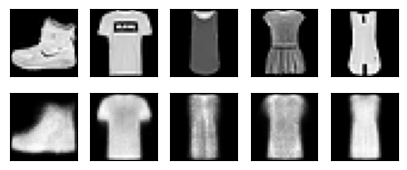

Train Error: 0.009864 

Validation Error: 0.009809 

Epoch 16
-------------------------------


782it [00:09, 85.80it/s]


[Epoch 15]


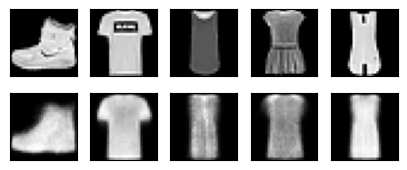

Train Error: 0.009645 

Validation Error: 0.009587 

Epoch 17
-------------------------------


782it [00:09, 79.95it/s]


[Epoch 16]


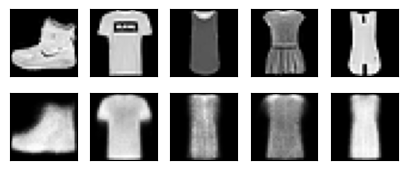

Train Error: 0.009423 

Validation Error: 0.009366 

Epoch 18
-------------------------------


782it [00:09, 79.22it/s]


[Epoch 17]


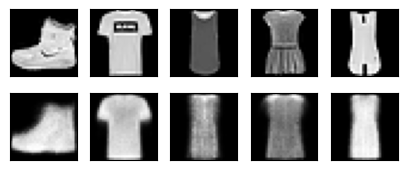

Train Error: 0.009209 

Validation Error: 0.009155 

Epoch 19
-------------------------------


782it [00:09, 84.46it/s]


[Epoch 18]


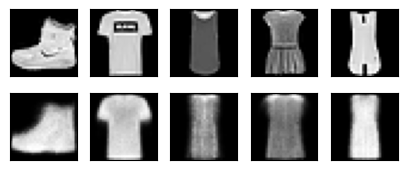

Train Error: 0.009046 

Validation Error: 0.008995 

Epoch 20
-------------------------------


782it [00:08, 90.46it/s]


[Epoch 19]


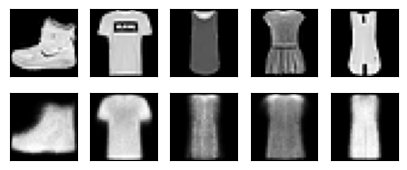

Train Error: 0.008916 

Validation Error: 0.008868 

Epoch 21
-------------------------------


782it [00:09, 86.53it/s]


[Epoch 20]


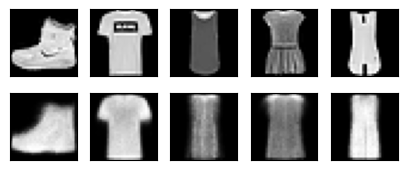

Train Error: 0.008803 

Validation Error: 0.008757 

Epoch 22
-------------------------------


782it [00:10, 78.17it/s]


[Epoch 21]


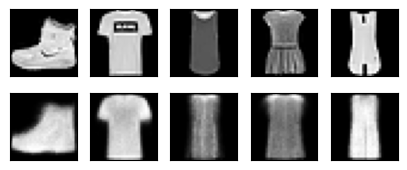

Train Error: 0.008704 

Validation Error: 0.008661 

Epoch 23
-------------------------------


782it [00:10, 77.02it/s]


[Epoch 22]


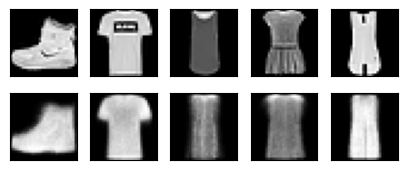

Train Error: 0.008614 

Validation Error: 0.008573 

Epoch 24
-------------------------------


782it [00:10, 75.98it/s]


[Epoch 23]


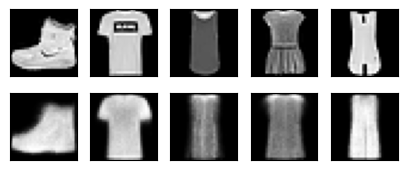

Train Error: 0.008529 

Validation Error: 0.008491 

Epoch 25
-------------------------------


782it [00:09, 80.39it/s]


[Epoch 24]


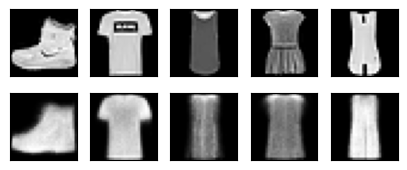

Train Error: 0.008448 

Validation Error: 0.008412 

Epoch 26
-------------------------------


782it [00:08, 87.37it/s]


[Epoch 25]


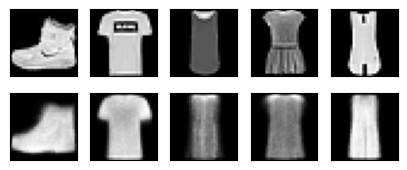

Train Error: 0.008366 

Validation Error: 0.008333 

Epoch 27
-------------------------------


782it [00:09, 85.23it/s]


[Epoch 26]


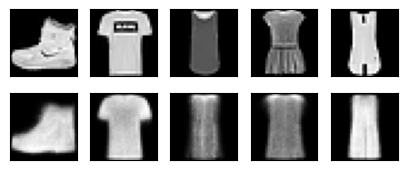

Train Error: 0.008279 

Validation Error: 0.008249 

Epoch 28
-------------------------------


782it [00:09, 80.00it/s]


[Epoch 27]


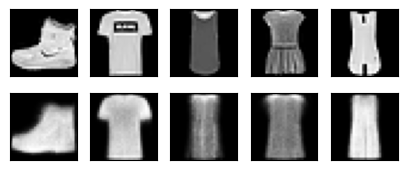

Train Error: 0.008179 

Validation Error: 0.008152 

Epoch 29
-------------------------------


782it [00:10, 75.49it/s]


[Epoch 28]


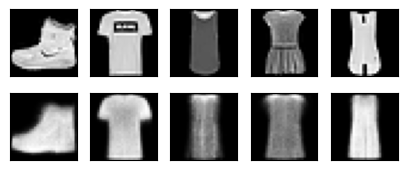

Train Error: 0.008056 

Validation Error: 0.008032 

Epoch 30
-------------------------------


782it [00:10, 73.60it/s]


[Epoch 29]


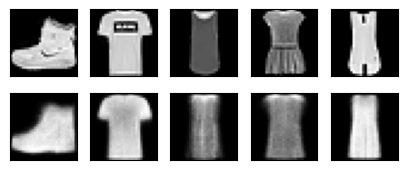

Train Error: 0.007928 

Validation Error: 0.007907 

Epoch 31
-------------------------------


782it [00:10, 75.19it/s]


[Epoch 30]


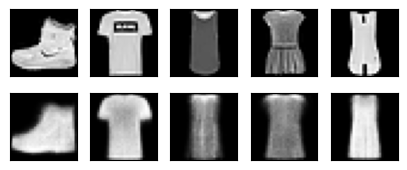

Train Error: 0.007816 

Validation Error: 0.007796 

Epoch 32
-------------------------------


782it [00:09, 82.35it/s]


[Epoch 31]


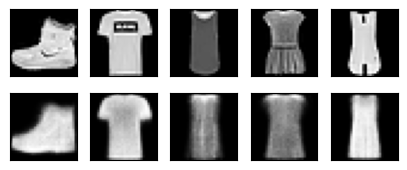

Train Error: 0.007724 

Validation Error: 0.007705 

Epoch 33
-------------------------------


782it [00:09, 85.83it/s]


[Epoch 32]


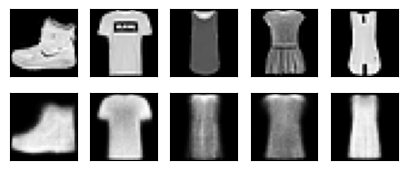

Train Error: 0.007648 

Validation Error: 0.007630 

Epoch 34
-------------------------------


782it [00:09, 83.18it/s]


[Epoch 33]


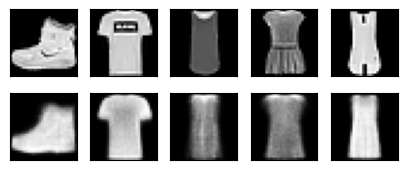

Train Error: 0.007581 

Validation Error: 0.007564 

Epoch 35
-------------------------------


782it [00:10, 75.97it/s]


[Epoch 34]


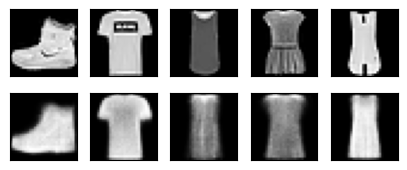

Train Error: 0.007521 

Validation Error: 0.007504 

Epoch 36
-------------------------------


782it [00:10, 72.56it/s]


[Epoch 35]


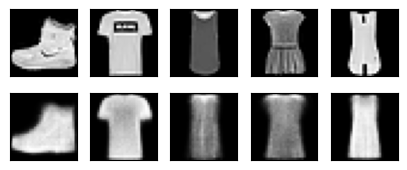

Train Error: 0.007466 

Validation Error: 0.007450 

Epoch 37
-------------------------------


782it [00:10, 72.35it/s]


[Epoch 36]


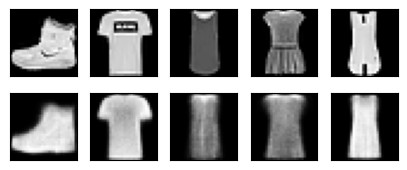

Train Error: 0.007414 

Validation Error: 0.007399 

Epoch 38
-------------------------------


782it [00:10, 74.20it/s]


[Epoch 37]


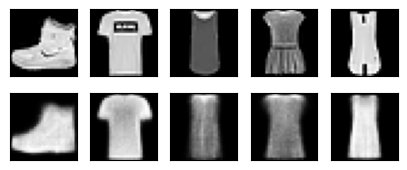

Train Error: 0.007364 

Validation Error: 0.007351 

Epoch 39
-------------------------------


782it [00:09, 78.94it/s]


[Epoch 38]


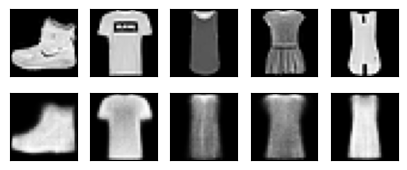

Train Error: 0.007315 

Validation Error: 0.007303 

Epoch 40
-------------------------------


782it [00:09, 82.59it/s]


[Epoch 39]


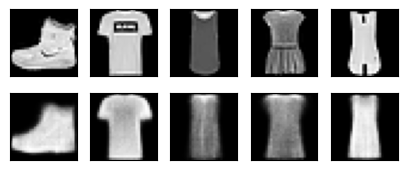

Train Error: 0.007265 

Validation Error: 0.007255 

Epoch 41
-------------------------------


782it [00:09, 83.16it/s]


[Epoch 40]


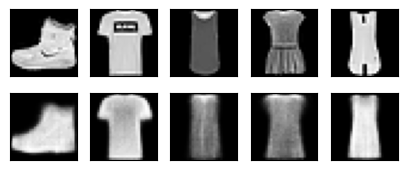

Train Error: 0.007218 

Validation Error: 0.007208 

Epoch 42
-------------------------------


782it [00:10, 77.49it/s]


[Epoch 41]


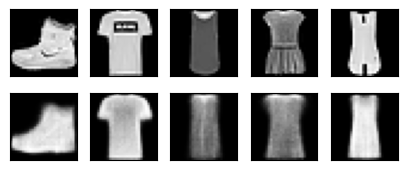

Train Error: 0.007173 

Validation Error: 0.007165 

Epoch 43
-------------------------------


782it [00:10, 71.69it/s]


[Epoch 42]


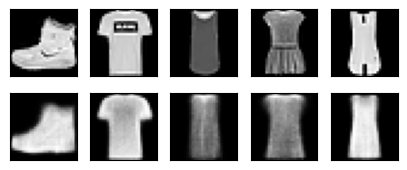

Train Error: 0.007131 

Validation Error: 0.007124 

Epoch 44
-------------------------------


782it [00:10, 71.28it/s]


[Epoch 43]


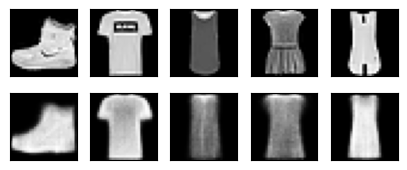

Train Error: 0.007092 

Validation Error: 0.007086 

Epoch 45
-------------------------------


782it [00:10, 73.02it/s]


[Epoch 44]


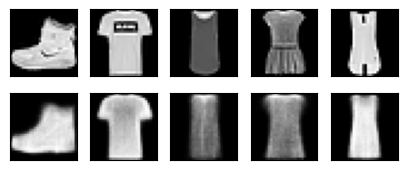

Train Error: 0.007056 

Validation Error: 0.007052 

Epoch 46
-------------------------------


782it [00:09, 78.85it/s]


[Epoch 45]


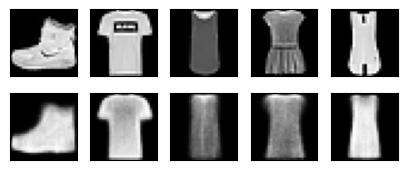

Train Error: 0.007021 

Validation Error: 0.007018 

Epoch 47
-------------------------------


782it [00:09, 83.66it/s]


[Epoch 46]


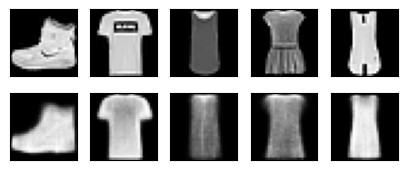

Train Error: 0.006988 

Validation Error: 0.006986 

Epoch 48
-------------------------------


782it [00:09, 80.73it/s]


[Epoch 47]


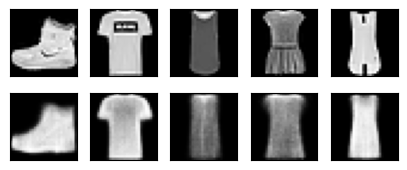

Train Error: 0.006955 

Validation Error: 0.006955 

Epoch 49
-------------------------------


782it [00:10, 74.85it/s]


[Epoch 48]


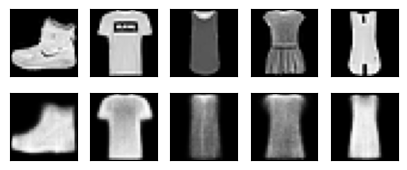

Train Error: 0.006923 

Validation Error: 0.006924 

Epoch 50
-------------------------------


782it [00:10, 71.25it/s]


[Epoch 49]


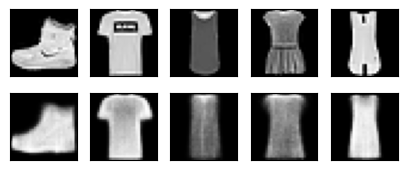

Train Error: 0.006891 

Validation Error: 0.006894 

Epoch 51
-------------------------------


782it [00:10, 72.28it/s]


[Epoch 50]


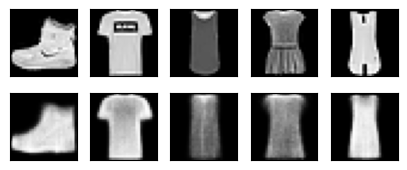

Train Error: 0.006860 

Validation Error: 0.006863 

Epoch 52
-------------------------------


782it [00:10, 77.25it/s]


[Epoch 51]


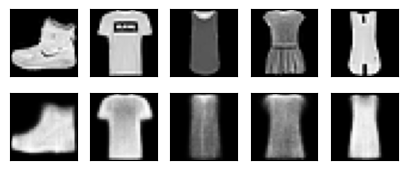

Train Error: 0.006829 

Validation Error: 0.006833 

Epoch 53
-------------------------------


782it [00:09, 82.20it/s]


[Epoch 52]


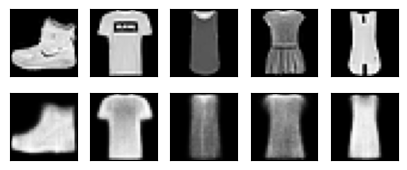

Train Error: 0.006797 

Validation Error: 0.006804 

Epoch 54
-------------------------------


782it [00:09, 80.31it/s]


[Epoch 53]


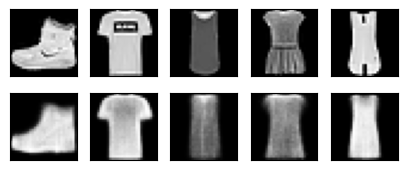

Train Error: 0.006766 

Validation Error: 0.006774 

Epoch 55
-------------------------------


782it [00:10, 75.50it/s]


[Epoch 54]


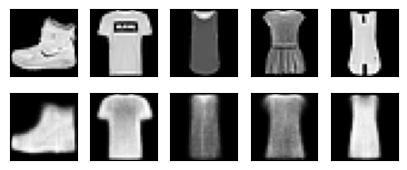

Train Error: 0.006736 

Validation Error: 0.006745 

Epoch 56
-------------------------------


782it [00:11, 69.88it/s]


[Epoch 55]


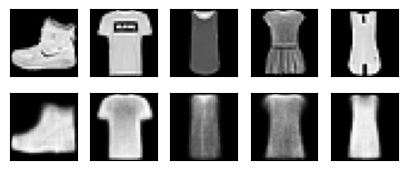

Train Error: 0.006706 

Validation Error: 0.006716 

Epoch 57
-------------------------------


782it [00:11, 68.85it/s]


[Epoch 56]


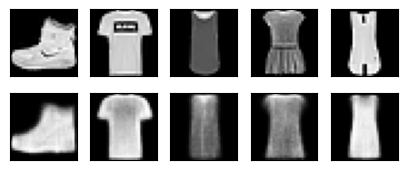

Train Error: 0.006676 

Validation Error: 0.006688 

Epoch 58
-------------------------------


782it [00:10, 71.62it/s]


[Epoch 57]


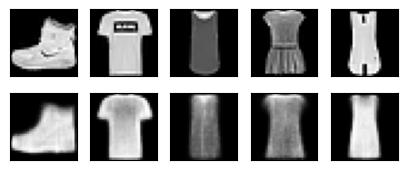

Train Error: 0.006646 

Validation Error: 0.006659 

Epoch 59
-------------------------------


782it [00:10, 73.03it/s]


[Epoch 58]


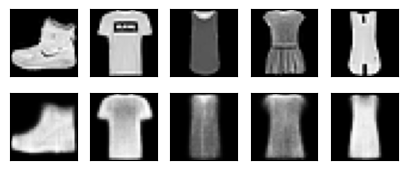

Train Error: 0.006615 

Validation Error: 0.006630 

Epoch 60
-------------------------------


782it [00:11, 70.19it/s]


[Epoch 59]


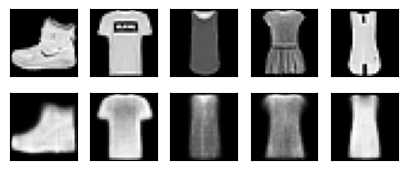

Train Error: 0.006585 

Validation Error: 0.006601 

Epoch 61
-------------------------------


782it [00:09, 78.54it/s]


[Epoch 60]


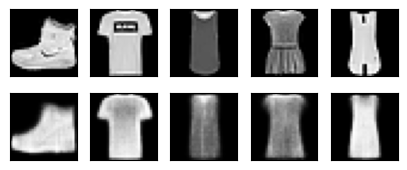

Train Error: 0.006554 

Validation Error: 0.006572 

Epoch 62
-------------------------------


782it [00:10, 78.09it/s]


[Epoch 61]


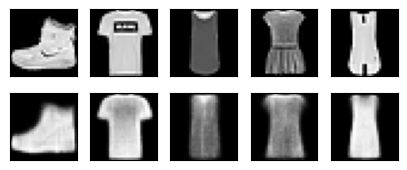

Train Error: 0.006524 

Validation Error: 0.006544 

Epoch 63
-------------------------------


782it [00:10, 73.08it/s]


[Epoch 62]


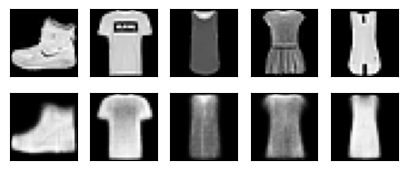

Train Error: 0.006494 

Validation Error: 0.006515 

Epoch 64
-------------------------------


782it [00:11, 68.33it/s]


[Epoch 63]


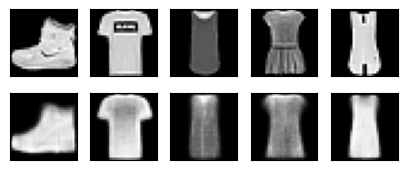

Train Error: 0.006465 

Validation Error: 0.006488 

Epoch 65
-------------------------------


782it [00:11, 66.58it/s]


[Epoch 64]


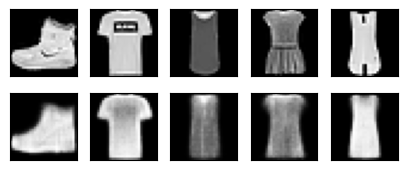

Train Error: 0.006437 

Validation Error: 0.006460 

Epoch 66
-------------------------------


782it [00:11, 66.08it/s]


[Epoch 65]


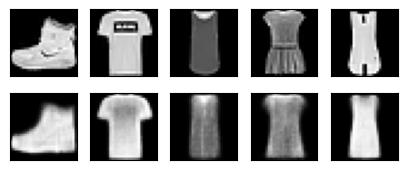

Train Error: 0.006408 

Validation Error: 0.006433 

Epoch 67
-------------------------------


782it [00:11, 69.36it/s]


[Epoch 66]


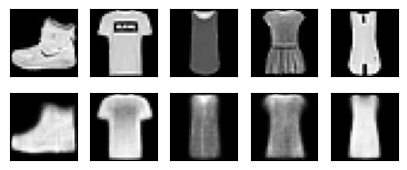

Train Error: 0.006380 

Validation Error: 0.006406 

Epoch 68
-------------------------------


782it [00:10, 73.99it/s]


[Epoch 67]


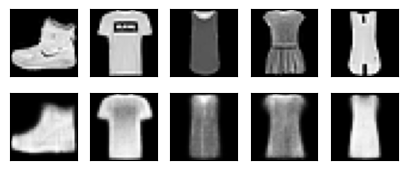

Train Error: 0.006352 

Validation Error: 0.006379 

Epoch 69
-------------------------------


782it [00:10, 76.32it/s]


[Epoch 68]


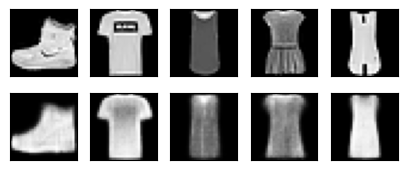

Train Error: 0.006324 

Validation Error: 0.006352 

Epoch 70
-------------------------------


782it [00:10, 76.60it/s]


[Epoch 69]


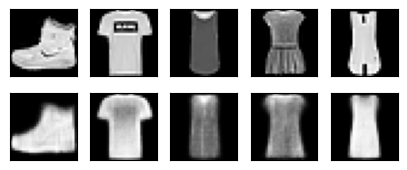

Train Error: 0.006296 

Validation Error: 0.006325 

Epoch 71
-------------------------------


782it [00:10, 75.53it/s]


[Epoch 70]


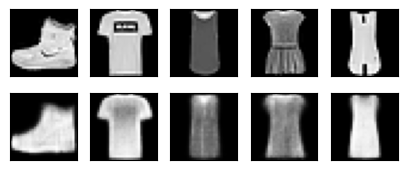

Train Error: 0.006269 

Validation Error: 0.006299 

Epoch 72
-------------------------------


782it [00:11, 70.75it/s]


[Epoch 71]


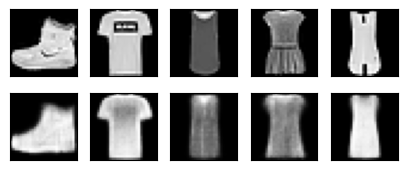

Train Error: 0.006242 

Validation Error: 0.006273 

Epoch 73
-------------------------------


782it [00:11, 67.12it/s]


[Epoch 72]


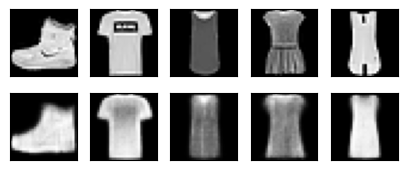

Train Error: 0.006216 

Validation Error: 0.006248 

Epoch 74
-------------------------------


782it [00:11, 65.83it/s]


[Epoch 73]


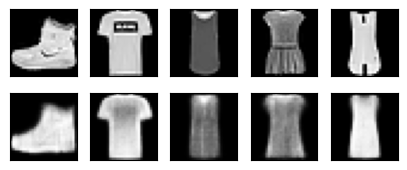

Train Error: 0.006190 

Validation Error: 0.006224 

Epoch 75
-------------------------------


782it [00:10, 72.02it/s]


[Epoch 74]


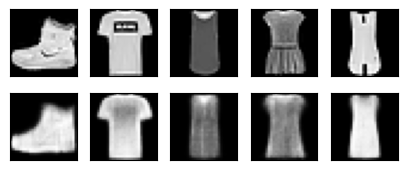

Train Error: 0.006167 

Validation Error: 0.006201 

Epoch 76
-------------------------------


782it [00:10, 75.26it/s]


[Epoch 75]


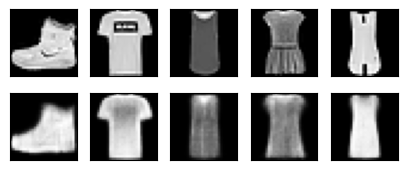

Train Error: 0.006144 

Validation Error: 0.006179 

Epoch 77
-------------------------------


782it [00:10, 76.05it/s]


[Epoch 76]


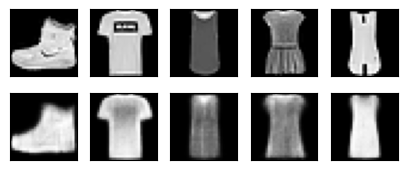

Train Error: 0.006122 

Validation Error: 0.006159 

Epoch 78
-------------------------------


782it [00:10, 75.49it/s]


[Epoch 77]


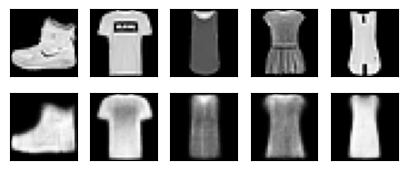

Train Error: 0.006102 

Validation Error: 0.006139 

Epoch 79
-------------------------------


782it [00:10, 72.57it/s]


[Epoch 78]


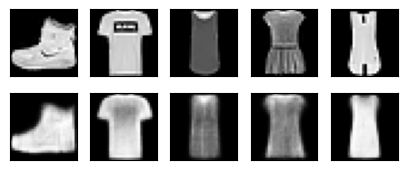

Train Error: 0.006082 

Validation Error: 0.006120 

Epoch 80
-------------------------------


782it [00:11, 65.54it/s]


[Epoch 79]


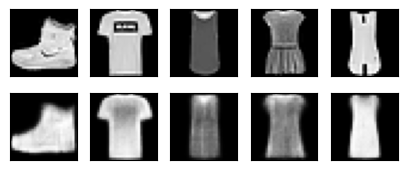

Train Error: 0.006063 

Validation Error: 0.006102 

Epoch 81
-------------------------------


782it [00:11, 65.17it/s]


[Epoch 80]


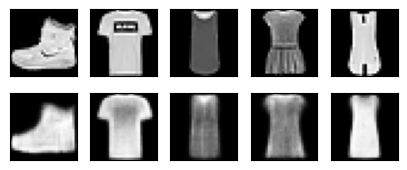

Train Error: 0.006044 

Validation Error: 0.006084 

Epoch 82
-------------------------------


782it [00:11, 68.18it/s]


[Epoch 81]


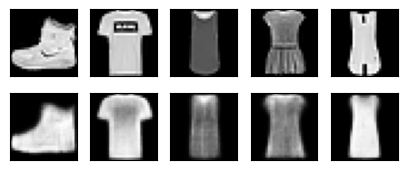

Train Error: 0.006026 

Validation Error: 0.006067 

Epoch 83
-------------------------------


782it [00:11, 70.98it/s]


[Epoch 82]


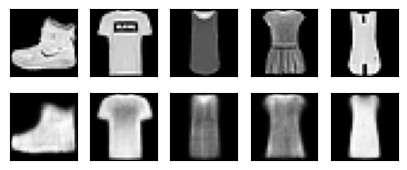

Train Error: 0.006008 

Validation Error: 0.006050 

Epoch 84
-------------------------------


782it [00:10, 73.56it/s]


[Epoch 83]


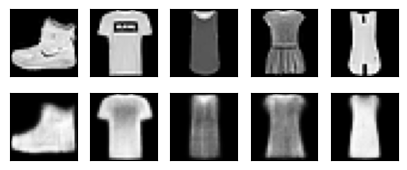

Train Error: 0.005990 

Validation Error: 0.006032 

Epoch 85
-------------------------------


782it [00:10, 74.82it/s]


[Epoch 84]


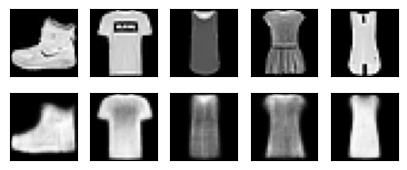

Train Error: 0.005972 

Validation Error: 0.006016 

Epoch 86
-------------------------------


782it [00:10, 72.96it/s]


[Epoch 85]


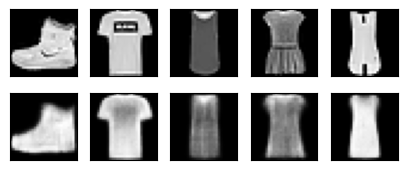

Train Error: 0.005954 

Validation Error: 0.005999 

Epoch 87
-------------------------------


782it [00:11, 69.98it/s]


[Epoch 86]


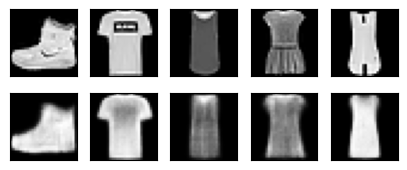

Train Error: 0.005937 

Validation Error: 0.005982 

Epoch 88
-------------------------------


782it [00:12, 63.44it/s]


[Epoch 87]


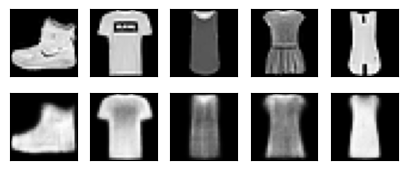

Train Error: 0.005919 

Validation Error: 0.005965 

Epoch 89
-------------------------------


782it [00:11, 66.25it/s]


[Epoch 88]


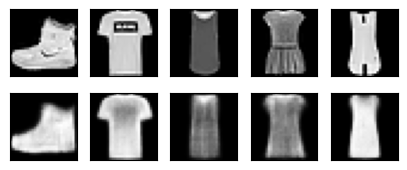

Train Error: 0.005901 

Validation Error: 0.005948 

Epoch 90
-------------------------------


782it [00:11, 69.09it/s]


[Epoch 89]


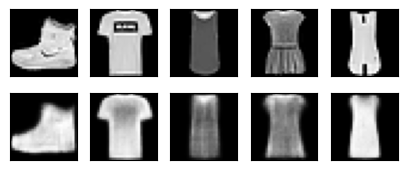

Train Error: 0.005884 

Validation Error: 0.005931 

Epoch 91
-------------------------------


782it [00:10, 71.27it/s]


[Epoch 90]


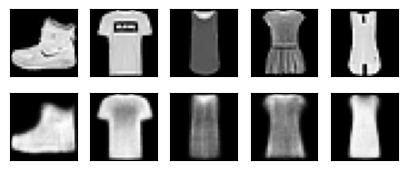

Train Error: 0.005866 

Validation Error: 0.005914 

Epoch 92
-------------------------------


782it [00:10, 73.23it/s]


[Epoch 91]


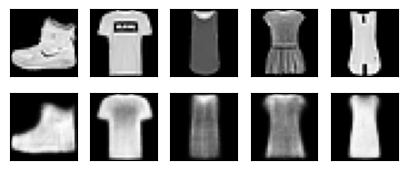

Train Error: 0.005849 

Validation Error: 0.005897 

Epoch 93
-------------------------------


782it [00:10, 72.81it/s]


[Epoch 92]


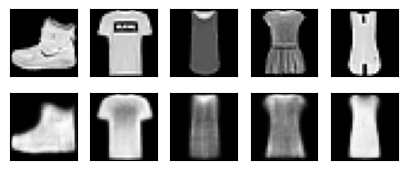

Train Error: 0.005832 

Validation Error: 0.005881 

Epoch 94
-------------------------------


782it [00:10, 71.69it/s]


[Epoch 93]


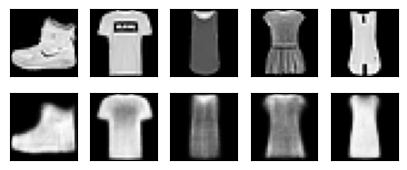

Train Error: 0.005815 

Validation Error: 0.005864 

Epoch 95
-------------------------------


782it [00:11, 67.53it/s]


[Epoch 94]


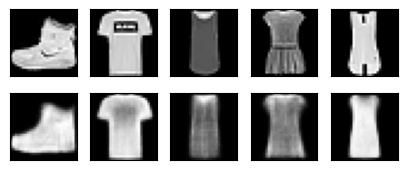

Train Error: 0.005798 

Validation Error: 0.005848 

Epoch 96
-------------------------------


782it [00:12, 63.27it/s]


[Epoch 95]


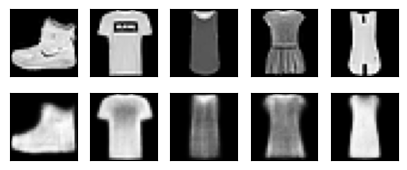

Train Error: 0.005782 

Validation Error: 0.005832 

Epoch 97
-------------------------------


782it [00:11, 65.27it/s]


[Epoch 96]


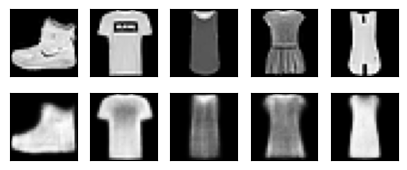

Train Error: 0.005766 

Validation Error: 0.005817 

Epoch 98
-------------------------------


782it [00:11, 70.82it/s]


[Epoch 97]


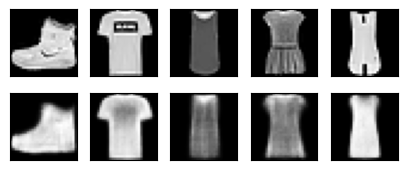

Train Error: 0.005750 

Validation Error: 0.005802 

Epoch 99
-------------------------------


782it [00:10, 71.69it/s]


[Epoch 98]


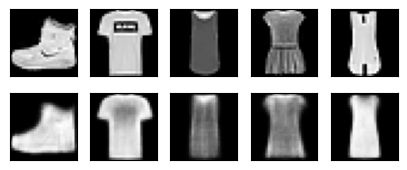

Train Error: 0.005735 

Validation Error: 0.005787 

Epoch 100
-------------------------------


782it [00:10, 73.02it/s]


[Epoch 99]


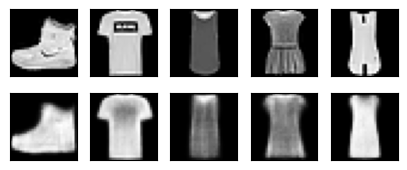

Train Error: 0.005719 

Validation Error: 0.005772 

Epoch 101
-------------------------------


782it [00:10, 71.98it/s]


[Epoch 100]


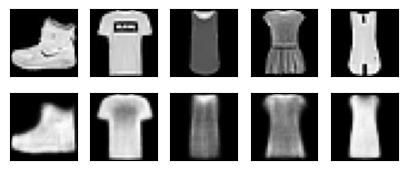

Train Error: 0.005704 

Validation Error: 0.005757 

Epoch 102
-------------------------------


782it [00:11, 69.26it/s]


[Epoch 101]


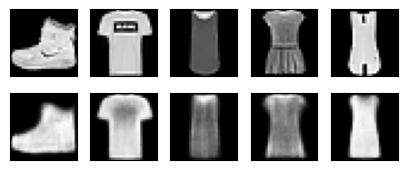

Train Error: 0.005688 

Validation Error: 0.005742 

Epoch 103
-------------------------------


782it [00:12, 63.05it/s]


[Epoch 102]


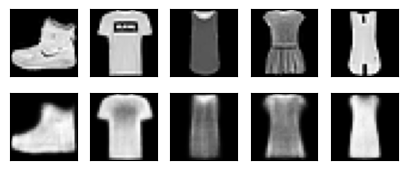

Train Error: 0.005673 

Validation Error: 0.005727 

Epoch 104
-------------------------------


782it [00:12, 63.08it/s]


[Epoch 103]


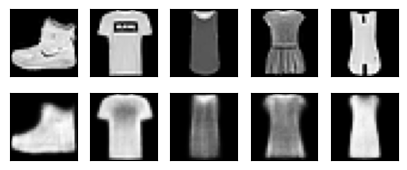

Train Error: 0.005658 

Validation Error: 0.005712 

Epoch 105
-------------------------------


782it [00:12, 65.04it/s]


[Epoch 104]


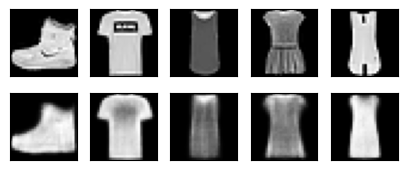

Train Error: 0.005643 

Validation Error: 0.005698 

Epoch 106
-------------------------------


782it [00:11, 69.43it/s]


[Epoch 105]


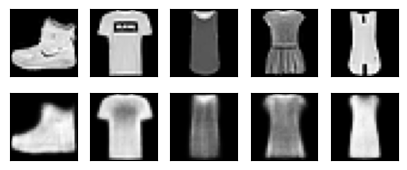

Train Error: 0.005628 

Validation Error: 0.005684 

Epoch 107
-------------------------------


782it [00:11, 71.04it/s]


[Epoch 106]


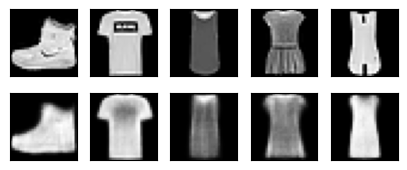

Train Error: 0.005614 

Validation Error: 0.005670 

Epoch 108
-------------------------------


782it [00:10, 71.74it/s]


[Epoch 107]


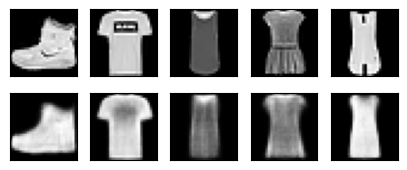

Train Error: 0.005600 

Validation Error: 0.005657 

Epoch 109
-------------------------------


782it [00:11, 70.21it/s]


[Epoch 108]


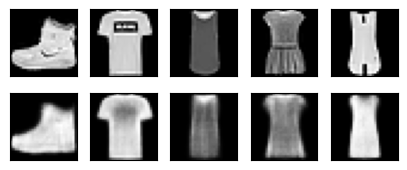

Train Error: 0.005587 

Validation Error: 0.005644 

Epoch 110
-------------------------------


782it [00:11, 67.84it/s]


[Epoch 109]


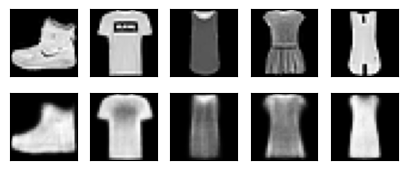

Train Error: 0.005573 

Validation Error: 0.005630 

Epoch 111
-------------------------------


782it [00:12, 63.34it/s]


[Epoch 110]


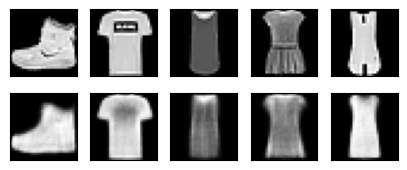

Train Error: 0.005559 

Validation Error: 0.005617 

Epoch 112
-------------------------------


782it [00:12, 61.09it/s]


[Epoch 111]


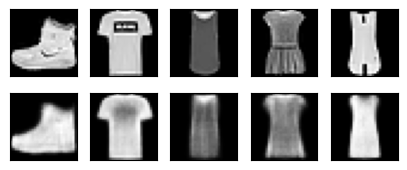

Train Error: 0.005546 

Validation Error: 0.005604 

Epoch 113
-------------------------------


782it [00:12, 63.48it/s]


[Epoch 112]


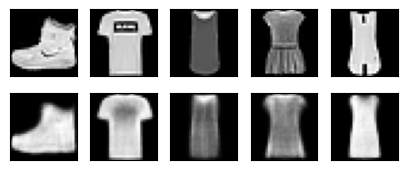

Train Error: 0.005533 

Validation Error: 0.005591 

Epoch 114
-------------------------------


782it [00:11, 69.46it/s]


[Epoch 113]


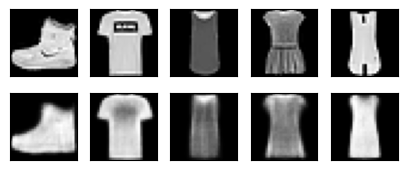

Train Error: 0.005519 

Validation Error: 0.005578 

Epoch 115
-------------------------------


782it [00:11, 70.23it/s]


[Epoch 114]


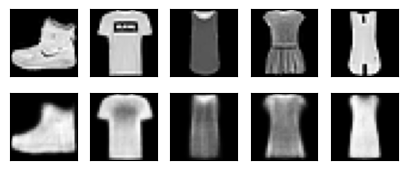

Train Error: 0.005506 

Validation Error: 0.005565 

Epoch 116
-------------------------------


782it [00:11, 70.65it/s]


[Epoch 115]


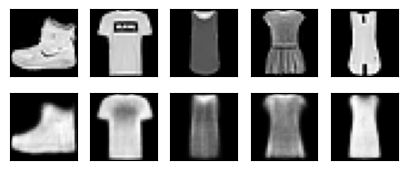

Train Error: 0.005492 

Validation Error: 0.005553 

Epoch 117
-------------------------------


782it [00:11, 68.72it/s]


[Epoch 116]


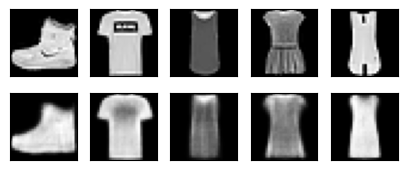

Train Error: 0.005479 

Validation Error: 0.005540 

Epoch 118
-------------------------------


782it [00:11, 67.15it/s]


[Epoch 117]


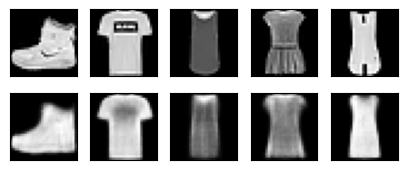

Train Error: 0.005466 

Validation Error: 0.005527 

Epoch 119
-------------------------------


782it [00:12, 62.31it/s]


[Epoch 118]


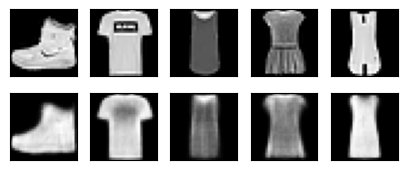

Train Error: 0.005453 

Validation Error: 0.005514 

Epoch 120
-------------------------------


782it [00:12, 60.23it/s]


[Epoch 119]


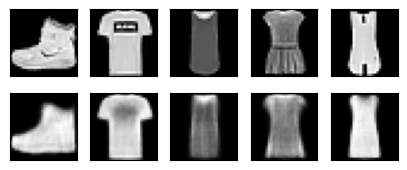

Train Error: 0.005439 

Validation Error: 0.005501 

Epoch 121
-------------------------------


782it [00:12, 62.11it/s]


[Epoch 120]


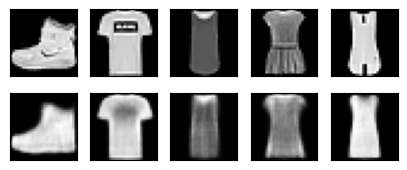

Train Error: 0.005426 

Validation Error: 0.005488 

Epoch 122
-------------------------------


782it [00:12, 64.89it/s]


[Epoch 121]


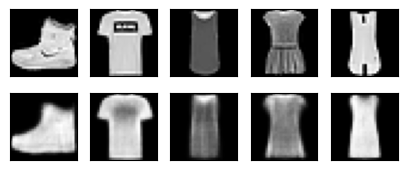

Train Error: 0.005414 

Validation Error: 0.005476 

Epoch 123
-------------------------------


782it [00:11, 65.68it/s]


[Epoch 122]


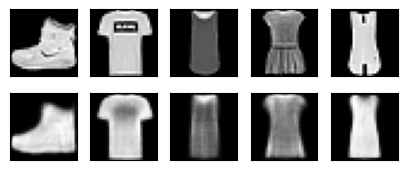

Train Error: 0.005401 

Validation Error: 0.005464 

Epoch 124
-------------------------------


782it [00:11, 69.16it/s]


[Epoch 123]


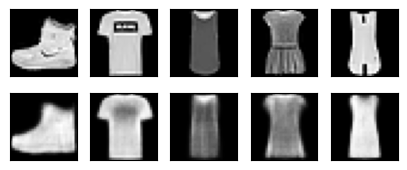

Train Error: 0.005389 

Validation Error: 0.005452 

Epoch 125
-------------------------------


782it [00:12, 64.46it/s]


[Epoch 124]


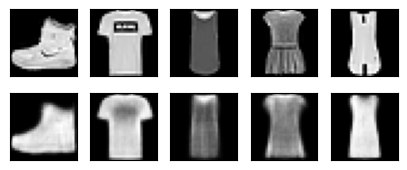

Train Error: 0.005377 

Validation Error: 0.005440 

Epoch 126
-------------------------------


782it [00:11, 67.00it/s]


[Epoch 125]


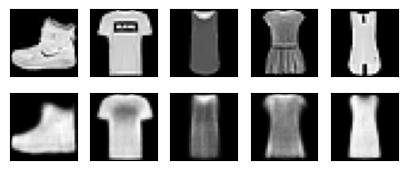

Train Error: 0.005365 

Validation Error: 0.005428 

Epoch 127
-------------------------------


782it [00:11, 67.95it/s]


[Epoch 126]


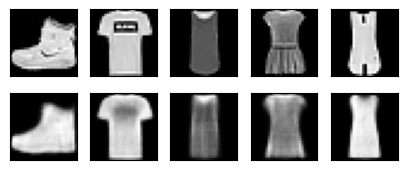

Train Error: 0.005354 

Validation Error: 0.005417 

Epoch 128
-------------------------------


782it [00:11, 67.42it/s]


[Epoch 127]


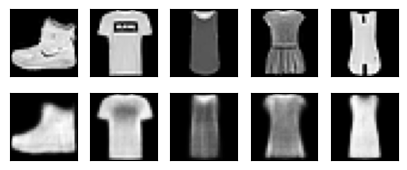

Train Error: 0.005342 

Validation Error: 0.005406 

Epoch 129
-------------------------------


782it [00:11, 66.01it/s]


[Epoch 128]


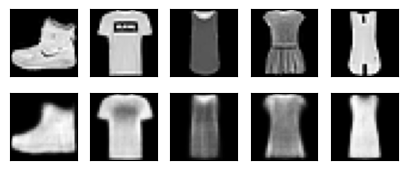

Train Error: 0.005331 

Validation Error: 0.005396 

Epoch 130
-------------------------------


782it [00:11, 65.67it/s]


[Epoch 129]


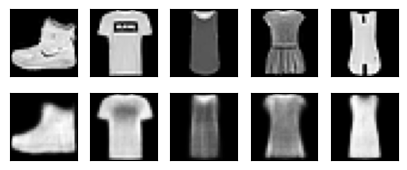

Train Error: 0.005320 

Validation Error: 0.005385 

Epoch 131
-------------------------------


782it [00:12, 62.55it/s]


[Epoch 130]


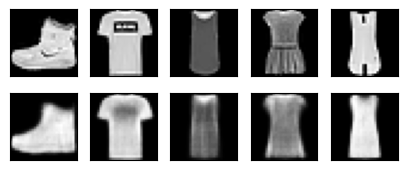

Train Error: 0.005310 

Validation Error: 0.005375 

Epoch 132
-------------------------------


782it [00:12, 62.13it/s]


[Epoch 131]


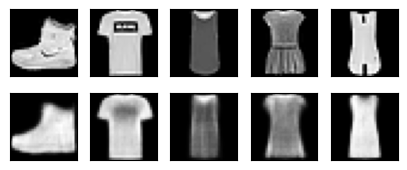

Train Error: 0.005299 

Validation Error: 0.005365 

Epoch 133
-------------------------------


782it [00:12, 60.99it/s]


[Epoch 132]


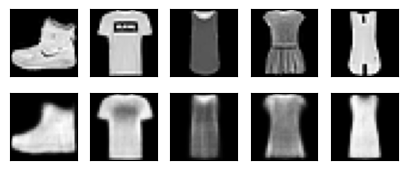

Train Error: 0.005289 

Validation Error: 0.005355 

Epoch 134
-------------------------------


782it [00:12, 61.43it/s]


[Epoch 133]


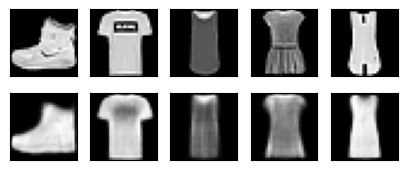

Train Error: 0.005278 

Validation Error: 0.005345 

Epoch 135
-------------------------------


782it [00:12, 64.28it/s]


[Epoch 134]


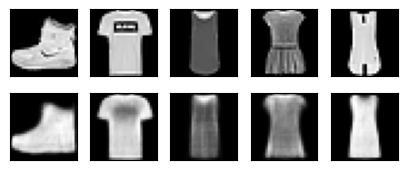

Train Error: 0.005268 

Validation Error: 0.005335 

Epoch 136
-------------------------------


782it [00:12, 64.54it/s]


[Epoch 135]


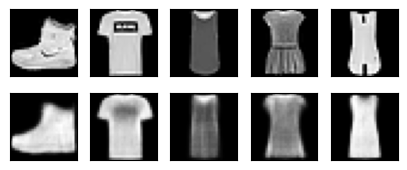

Train Error: 0.005258 

Validation Error: 0.005326 

Epoch 137
-------------------------------


782it [00:11, 65.51it/s]


[Epoch 136]


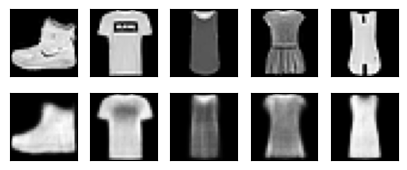

Train Error: 0.005248 

Validation Error: 0.005316 

Epoch 138
-------------------------------


782it [00:11, 66.62it/s]


[Epoch 137]


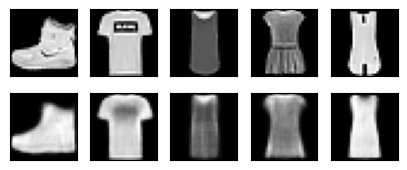

Train Error: 0.005239 

Validation Error: 0.005307 

Epoch 139
-------------------------------


782it [00:11, 66.22it/s]


[Epoch 138]


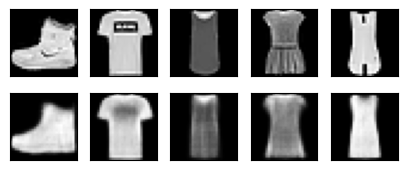

Train Error: 0.005229 

Validation Error: 0.005298 

Epoch 140
-------------------------------


782it [00:11, 66.35it/s]


[Epoch 139]


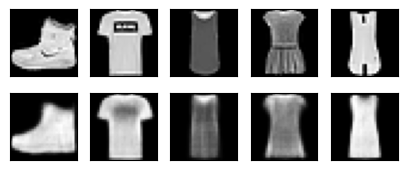

Train Error: 0.005219 

Validation Error: 0.005289 

Epoch 141
-------------------------------


782it [00:12, 64.50it/s]


[Epoch 140]


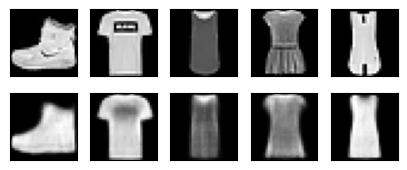

Train Error: 0.005210 

Validation Error: 0.005280 

Epoch 142
-------------------------------


782it [00:11, 65.31it/s]


[Epoch 141]


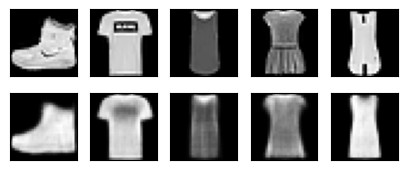

Train Error: 0.005200 

Validation Error: 0.005271 

Epoch 143
-------------------------------


782it [00:12, 64.23it/s]


[Epoch 142]


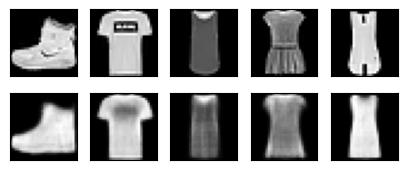

Train Error: 0.005191 

Validation Error: 0.005263 

Epoch 144
-------------------------------


782it [00:12, 65.03it/s]


[Epoch 143]


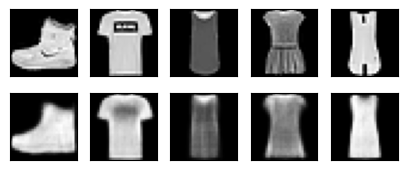

Train Error: 0.005182 

Validation Error: 0.005254 

Epoch 145
-------------------------------


782it [00:12, 64.51it/s]


[Epoch 144]


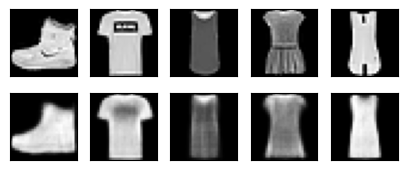

Train Error: 0.005173 

Validation Error: 0.005245 

Epoch 146
-------------------------------


782it [00:12, 63.71it/s]


[Epoch 145]


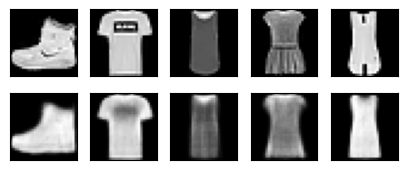

Train Error: 0.005164 

Validation Error: 0.005237 

Epoch 147
-------------------------------


782it [00:12, 64.27it/s]


[Epoch 146]


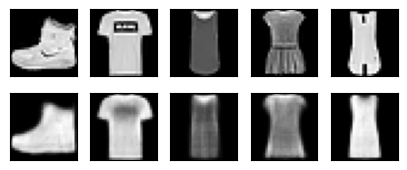

Train Error: 0.005155 

Validation Error: 0.005228 

Epoch 148
-------------------------------


782it [00:12, 62.91it/s]


[Epoch 147]


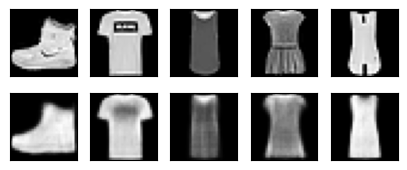

Train Error: 0.005146 

Validation Error: 0.005220 

Epoch 149
-------------------------------


782it [00:12, 64.54it/s]


[Epoch 148]


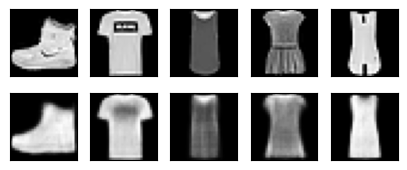

Train Error: 0.005137 

Validation Error: 0.005212 

Epoch 150
-------------------------------


782it [00:12, 63.74it/s]


[Epoch 149]


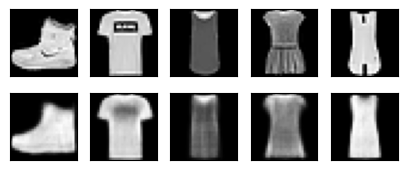

Train Error: 0.005128 

Validation Error: 0.005203 

Epoch 151
-------------------------------


782it [00:12, 64.12it/s]


[Epoch 150]


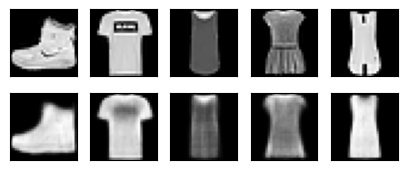

Train Error: 0.005120 

Validation Error: 0.005195 

Epoch 152
-------------------------------


782it [00:12, 63.00it/s]


[Epoch 151]


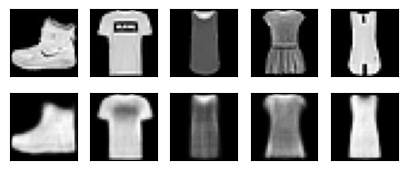

Train Error: 0.005111 

Validation Error: 0.005187 

Epoch 153
-------------------------------


782it [00:12, 62.13it/s]


[Epoch 152]


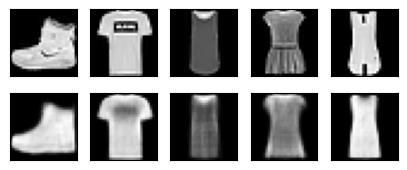

Train Error: 0.005102 

Validation Error: 0.005179 

Epoch 154
-------------------------------


782it [00:12, 61.86it/s]


[Epoch 153]


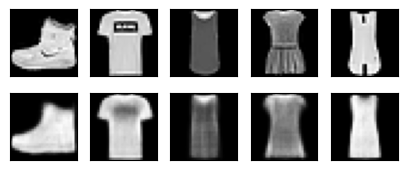

Train Error: 0.005094 

Validation Error: 0.005171 

Epoch 155
-------------------------------


782it [00:12, 63.55it/s]


[Epoch 154]


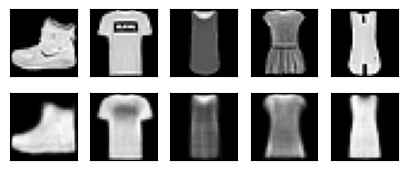

Train Error: 0.005085 

Validation Error: 0.005163 

Epoch 156
-------------------------------


782it [00:12, 61.78it/s]


[Epoch 155]


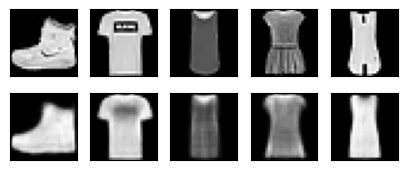

Train Error: 0.005077 

Validation Error: 0.005155 

Epoch 157
-------------------------------


782it [00:12, 61.76it/s]


[Epoch 156]


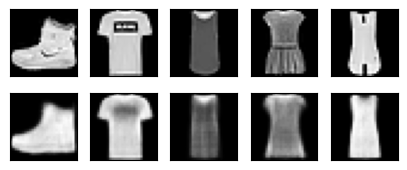

Train Error: 0.005068 

Validation Error: 0.005147 

Epoch 158
-------------------------------


782it [00:12, 61.16it/s]


[Epoch 157]


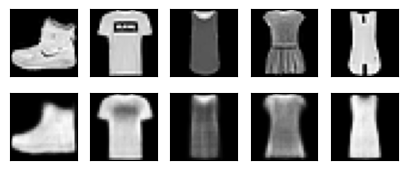

Train Error: 0.005060 

Validation Error: 0.005139 

Epoch 159
-------------------------------


782it [00:12, 61.82it/s]


[Epoch 158]


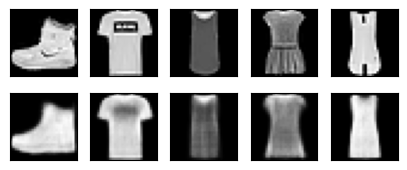

Train Error: 0.005052 

Validation Error: 0.005132 

Epoch 160
-------------------------------


782it [00:13, 59.40it/s]


[Epoch 159]


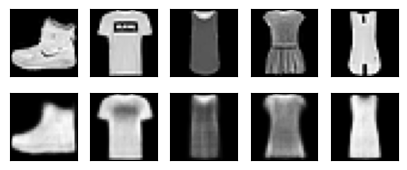

Train Error: 0.005044 

Validation Error: 0.005124 

Epoch 161
-------------------------------


782it [00:12, 61.83it/s]


[Epoch 160]


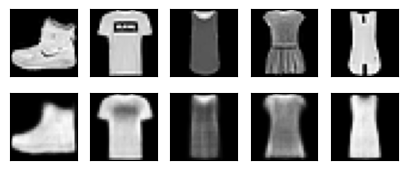

Train Error: 0.005036 

Validation Error: 0.005117 

Epoch 162
-------------------------------


782it [00:12, 62.43it/s]


[Epoch 161]


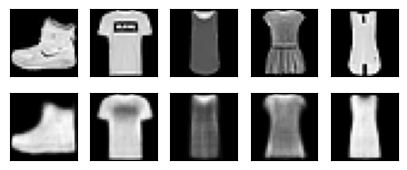

Train Error: 0.005029 

Validation Error: 0.005110 

Epoch 163
-------------------------------


782it [00:12, 61.69it/s]


[Epoch 162]


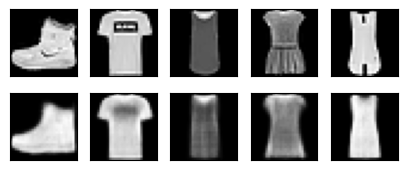

Train Error: 0.005021 

Validation Error: 0.005103 

Epoch 164
-------------------------------


782it [00:12, 64.86it/s]


[Epoch 163]


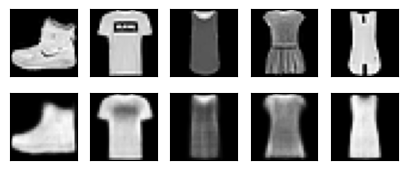

Train Error: 0.005014 

Validation Error: 0.005096 

Epoch 165
-------------------------------


782it [00:12, 64.61it/s]


[Epoch 164]


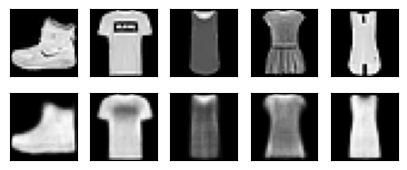

Train Error: 0.005006 

Validation Error: 0.005089 

Epoch 166
-------------------------------


782it [00:12, 63.07it/s]


[Epoch 165]


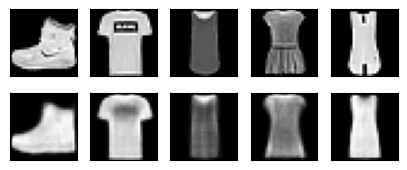

Train Error: 0.004999 

Validation Error: 0.005082 

Epoch 167
-------------------------------


782it [00:12, 61.80it/s]


[Epoch 166]


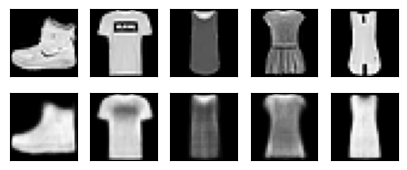

Train Error: 0.004992 

Validation Error: 0.005076 

Epoch 168
-------------------------------


782it [00:12, 60.54it/s]


[Epoch 167]


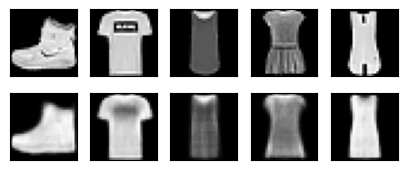

Train Error: 0.004985 

Validation Error: 0.005069 

Epoch 169
-------------------------------


782it [00:12, 60.59it/s]


[Epoch 168]


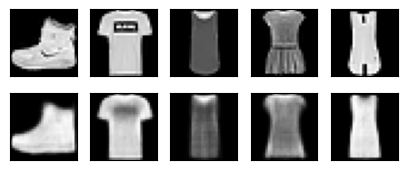

Train Error: 0.004977 

Validation Error: 0.005062 

Epoch 170
-------------------------------


782it [00:12, 61.86it/s]


[Epoch 169]


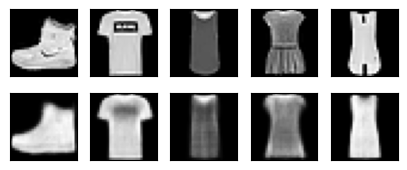

Train Error: 0.004970 

Validation Error: 0.005056 

Epoch 171
-------------------------------


782it [00:12, 63.65it/s]


[Epoch 170]


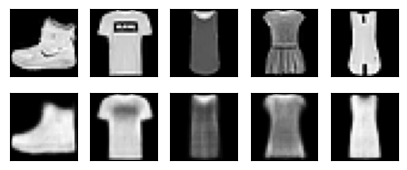

Train Error: 0.004963 

Validation Error: 0.005049 

Epoch 172
-------------------------------


782it [00:12, 62.95it/s]


[Epoch 171]


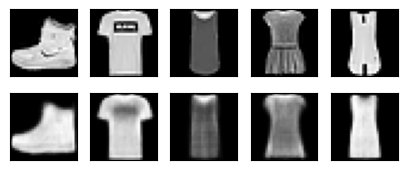

Train Error: 0.004956 

Validation Error: 0.005043 

Epoch 173
-------------------------------


782it [00:12, 60.76it/s]


[Epoch 172]


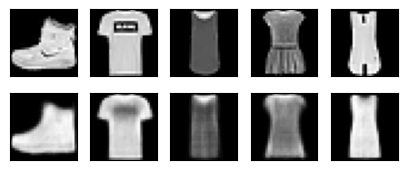

Train Error: 0.004949 

Validation Error: 0.005037 

Epoch 174
-------------------------------


782it [00:12, 63.06it/s]


[Epoch 173]


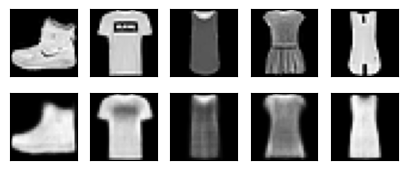

Train Error: 0.004943 

Validation Error: 0.005030 

Epoch 175
-------------------------------


782it [00:12, 62.43it/s]


[Epoch 174]


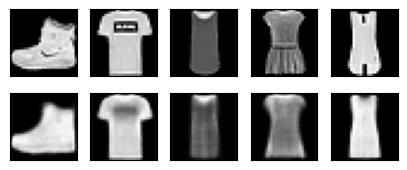

Train Error: 0.004936 

Validation Error: 0.005024 

Epoch 176
-------------------------------


782it [00:12, 63.09it/s]


[Epoch 175]


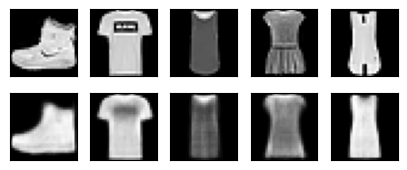

Train Error: 0.004929 

Validation Error: 0.005017 

Epoch 177
-------------------------------


782it [00:12, 62.26it/s]


[Epoch 176]


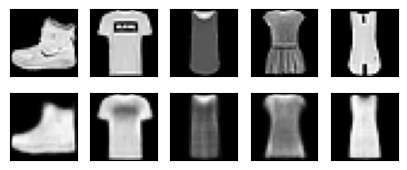

Train Error: 0.004922 

Validation Error: 0.005011 

Epoch 178
-------------------------------


782it [00:12, 62.61it/s]


[Epoch 177]


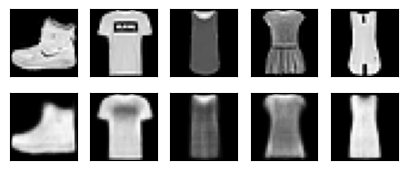

Train Error: 0.004915 

Validation Error: 0.005005 

Epoch 179
-------------------------------


782it [00:12, 60.35it/s]


[Epoch 178]


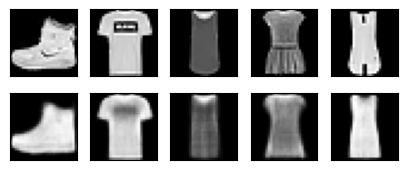

Train Error: 0.004908 

Validation Error: 0.004998 

Epoch 180
-------------------------------


782it [00:12, 60.88it/s]


[Epoch 179]


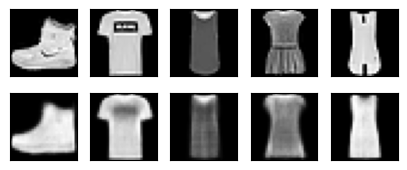

Train Error: 0.004902 

Validation Error: 0.004992 

Epoch 181
-------------------------------


782it [00:12, 60.41it/s]


[Epoch 180]


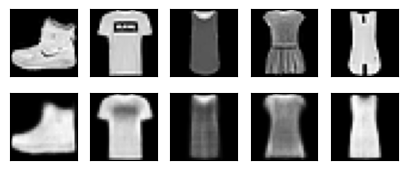

Train Error: 0.004895 

Validation Error: 0.004986 

Epoch 182
-------------------------------


782it [00:13, 59.50it/s]


[Epoch 181]


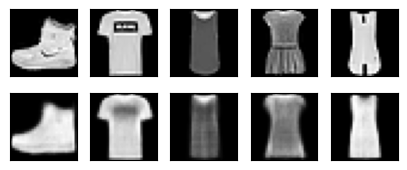

Train Error: 0.004888 

Validation Error: 0.004980 

Epoch 183
-------------------------------


782it [00:12, 63.10it/s]


[Epoch 182]


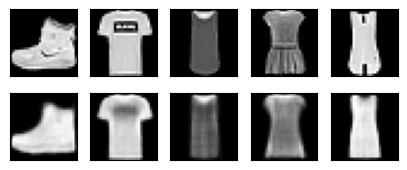

Train Error: 0.004881 

Validation Error: 0.004973 

Epoch 184
-------------------------------


782it [00:12, 62.73it/s]


[Epoch 183]


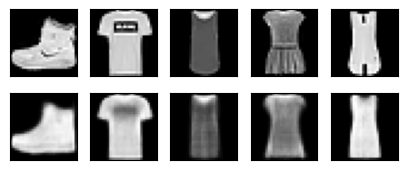

Train Error: 0.004874 

Validation Error: 0.004967 

Epoch 185
-------------------------------


782it [00:12, 62.16it/s]


[Epoch 184]


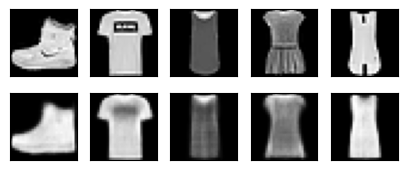

Train Error: 0.004868 

Validation Error: 0.004960 

Epoch 186
-------------------------------


782it [00:12, 62.35it/s]


[Epoch 185]


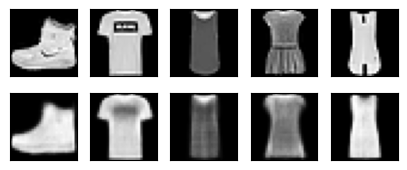

Train Error: 0.004861 

Validation Error: 0.004954 

Epoch 187
-------------------------------


782it [00:12, 61.76it/s]


[Epoch 186]


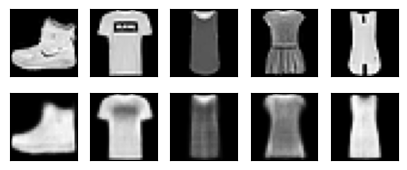

Train Error: 0.004854 

Validation Error: 0.004948 

Epoch 188
-------------------------------


782it [00:12, 63.09it/s]


[Epoch 187]


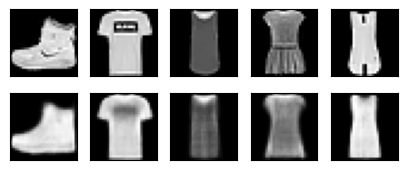

Train Error: 0.004847 

Validation Error: 0.004941 

Epoch 189
-------------------------------


782it [00:12, 62.16it/s]


[Epoch 188]


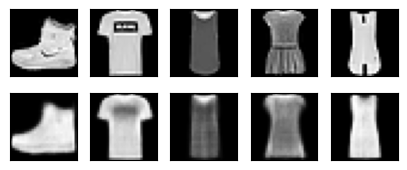

Train Error: 0.004840 

Validation Error: 0.004935 

Epoch 190
-------------------------------


782it [00:12, 62.20it/s]


[Epoch 189]


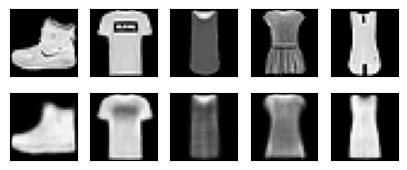

Train Error: 0.004833 

Validation Error: 0.004928 

Epoch 191
-------------------------------


782it [00:13, 58.60it/s]


[Epoch 190]


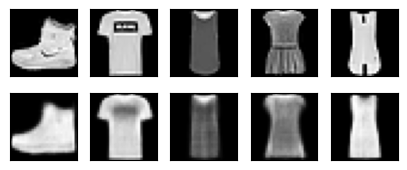

Train Error: 0.004826 

Validation Error: 0.004922 

Epoch 192
-------------------------------


782it [00:13, 59.18it/s]


[Epoch 191]


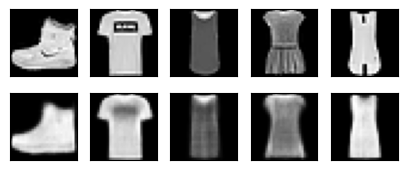

Train Error: 0.004819 

Validation Error: 0.004915 

Epoch 193
-------------------------------


782it [00:13, 59.69it/s]


[Epoch 192]


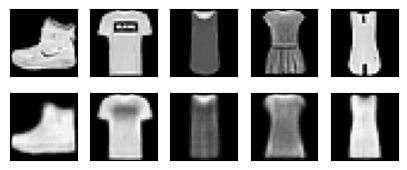

Train Error: 0.004812 

Validation Error: 0.004909 

Epoch 194
-------------------------------


782it [00:12, 62.43it/s]


[Epoch 193]


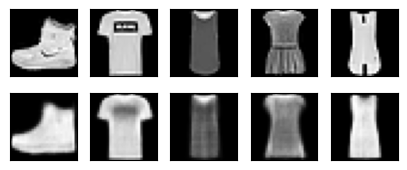

Train Error: 0.004805 

Validation Error: 0.004902 

Epoch 195
-------------------------------


782it [00:13, 58.86it/s]


[Epoch 194]


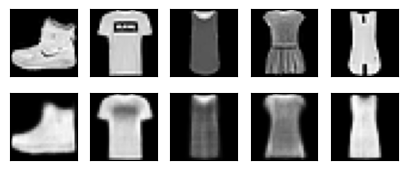

Train Error: 0.004799 

Validation Error: 0.004896 

Epoch 196
-------------------------------


782it [00:13, 58.86it/s]


[Epoch 195]


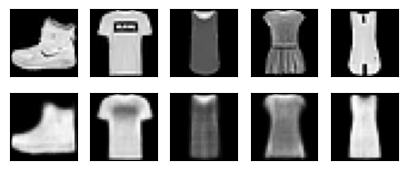

Train Error: 0.004792 

Validation Error: 0.004890 

Epoch 197
-------------------------------


782it [00:12, 62.13it/s]


[Epoch 196]


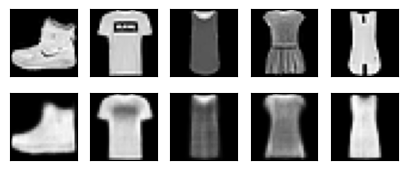

Train Error: 0.004785 

Validation Error: 0.004884 

Epoch 198
-------------------------------


782it [00:12, 63.65it/s]


[Epoch 197]


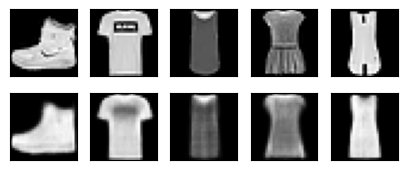

Train Error: 0.004778 

Validation Error: 0.004877 

Epoch 199
-------------------------------


782it [00:12, 63.94it/s]


[Epoch 198]


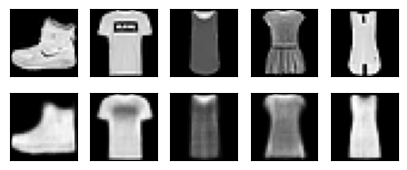

Train Error: 0.004772 

Validation Error: 0.004871 

Epoch 200
-------------------------------


782it [00:12, 63.13it/s]


[Epoch 199]


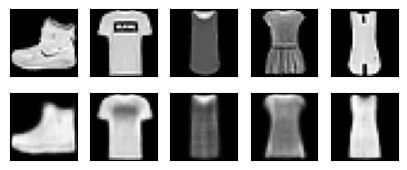

Train Error: 0.004765 

Validation Error: 0.004865 

Done!


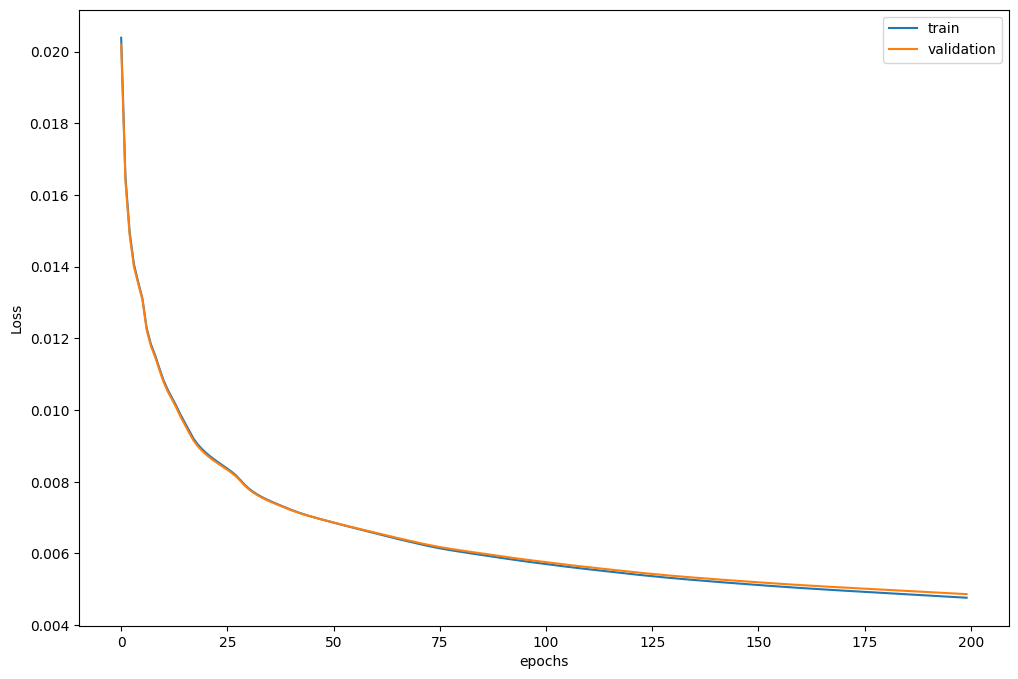

In [9]:
# 학습을 진행합니다.
train_loss_list = []

val_loss_list = []

for t in range((EPOCHS)):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)

    train_loss = test(train_dataloader, model, loss_fn)

    f, a = plt.subplots(2,5,figsize=(5,2))
    print("[Epoch {}]".format(t))
    for i in range(5):
      img = np.reshape(view_data.data.numpy()[i],(28,28))
      a[0][i].imshow(img, cmap="gray")
      a[0][i].set_xticks(())
      a[0][i].set_yticks(())

    for i in range(5):
      recon = model(view_data.to(device))
      img = np.reshape(recon.data.numpy()[i],(28,28))
      a[1][i].imshow(img, cmap="gray")
      a[1][i].set_xticks(())
      a[1][i].set_yticks(())
    plt.show()

    print(f"Train Error: {train_loss:>8f} \n")
    train_loss_list.append(train_loss)

    val_loss = test(validation_dataloader, model, loss_fn)
    print(f"Validation Error: {val_loss:>8f} \n")
    val_loss_list.append(val_loss)

print("Done!")

plt.figure(figsize=(12,8))

plt.plot(train_loss_list,label="train")
plt.plot(val_loss_list,label="validation")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend()

In [10]:
test_loss = test(test_dataloader, model, loss_fn)
print(f"Test Error: {test_loss:>8f} \n")


Test Error: 0.004953 



# Task 1: Denoising

In [11]:
def add_noise(img):
  noise = torch.randn(img.size()) * 0.3
  noisy_img = img + noise
  return noisy_img

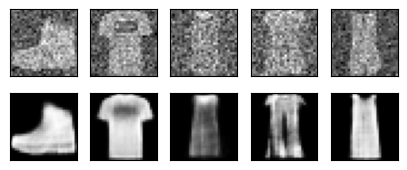

In [12]:
f, a = plt.subplots(2,5,figsize=(5,2))

for i in range(5):
  noisy_data = add_noise(view_data)
  img = np.reshape(noisy_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(noisy_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()

# Task 2: Anomaly detection

In [13]:
def anomaly_detection(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = []

    with torch.no_grad():
        for batch, (X,y) in enumerate(dataloader):
            X = X.view(-1,28*28).to(device)

            recon = model(X)
            loss = loss_fn(recon, X)
            test_loss.append(loss)
    return test_loss

In [14]:
# 학습때 경험하지 못한 MNIST 데이터를 비정상 데이터로 활용하여, anomaly detection을 진행합니다.
# 공개 데이터셋에서 테스트 데이터를 내려받습니다.
abnor_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

abnor_dataloader = DataLoader(abnor_data, batch_size=len(test_data))

view_abnor_data = abnor_data.data[:5].view(-1,28*28)
view_abnor_data = view_abnor_data.type(torch.FloatTensor)/255.

100%|██████████| 9912422/9912422 [00:00<00:00, 63550434.79it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21041461.49it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28892900.73it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3819272.01it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [15]:
normal_score = anomaly_detection(test_dataloader, model, loss_fn)
abnormal_score = anomaly_detection(abnor_dataloader, model, loss_fn)

In [16]:
len(test_data)

10000

In [17]:
len(abnor_data)

10000

Text(0, 0.5, 'count')

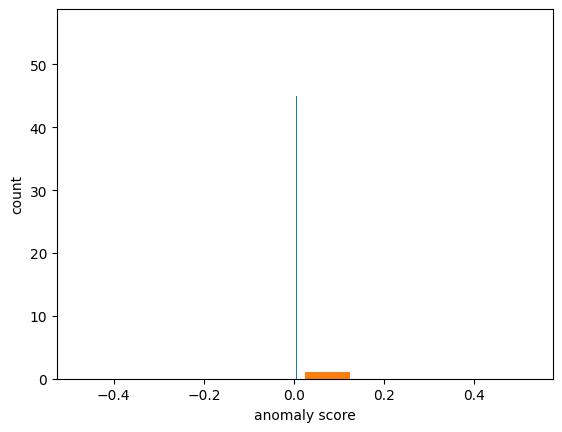

In [18]:
bins_list = []
for i in range(200):
  bins_list.append(i*0.002)
plt.hist(normal_score)
plt.hist(abnormal_score)

plt.xlabel("anomaly score")
plt.ylabel("count")

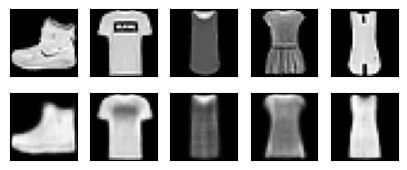

In [19]:
f, a = plt.subplots(2,5,figsize=(5,2))


for i in range(5):
  img = np.reshape(view_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(view_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()

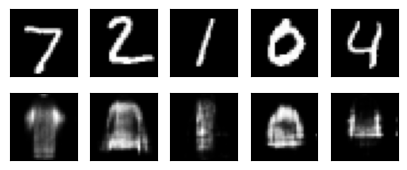

In [20]:
f, a = plt.subplots(2,5,figsize=(5,2))


for i in range(5):
  img = np.reshape(view_abnor_data.data.numpy()[i],(28,28))
  a[0][i].imshow(img, cmap="gray")
  a[0][i].set_xticks(())
  a[0][i].set_yticks(())

for i in range(5):

  recon = model(view_abnor_data.to(device))
  img = np.reshape(recon.data.numpy()[i],(28,28))
  a[1][i].imshow(img, cmap="gray")
  a[1][i].set_xticks(())
  a[1][i].set_yticks(())
plt.show()